In [1]:
# import process_data
import pandas as pd
import random
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import math
from pathlib import Path

from stable_baselines.common.env_checker import check_env


# import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, LSTM
from keras.optimizers import Adam

# keras-rl agent
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

# custom normalizer
# from util import NormalizerProcessor

Using TensorFlow backend.


In [3]:
config_dir = '/home/andrew/All_Trading/Studies/Omni_Project/Primary_Assets/US_Dollar_Index/Config1/'
rl_dir = config_dir + 'RL/'

In [4]:
all_minutesDF = pd.read_csv(config_dir+'Data/all_minutes.csv', nrows=20000)

In [18]:
all_minutesDF.C_B1.ffill(inplace=True)

In [26]:
all_minutesDF[['C_B1']].ewm(com=3).mean()['C_B1']

0        92.826000
1        92.817429
2        92.797784
3        92.788720
4        92.784878
           ...    
19995    91.221983
19996    91.215487
19997    91.207365
19998    91.213774
19999    91.215580
Name: C_B1, Length: 20000, dtype: float64

In [34]:
all_minutesDF['C_B1_EMA5'] = all_minutesDF[['C_B1']].ewm(com=5).mean()['C_B1']
all_minutesDF['C_B1_EMA15'] = all_minutesDF[['C_B1']].ewm(com=15).mean()['C_B1']
all_minutesDF['C_B1_EMA30'] = all_minutesDF[['C_B1']].ewm(com=30).mean()['C_B1']
all_minutesDF['C_B1_EMA60'] = all_minutesDF[['C_B1']].ewm(com=60).mean()['C_B1']

all_minutesDF['C_B1_shift'] = all_minutesDF.C_B1.shift(5)


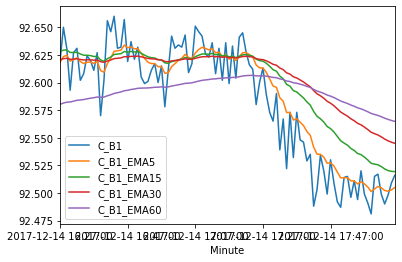

In [35]:

all_minutesDF[4500:4600].plot(x='Minute', y=['C_B1', 'C_B1_EMA5', 'C_B1_EMA15', 'C_B1_EMA30', 'C_B1_EMA60'])#, ylim=(92, 93.5))
# plt.show()

In [3]:
# # generate the close_prices csv
# trainY = pd.read_csv(config_dir+'Preprocessed_Data/train_minutesDF_y.csv')
# valY = pd.read_csv(config_dir+'Preprocessed_Data/train_minutesDF_y.csv')
# all_minutesDF = pd.read_csv(config_dir+'Data/all_minutes.csv')


In [4]:
# close_cols = [i for i in all_minutesDF.columns if i[:2]=='C_']
# train_closeDF = pd.merge(trainY[['Minute']], all_minutesDF[['Minute']+close_cols], on='Minute')
# train_closeDF = train_closeDF.ffill()

# val_closeDF = pd.merge(valY[['Minute']], all_minutesDF[['Minute']+close_cols], on='Minute')
# val_closeDF = val_closeDF.ffill()

# train_closeDF.to_csv(config_dir+'Preprocessed_Data/train_close_prices.csv', index=False)
# train_closeDF.to_csv(config_dir+'Preprocessed_Data/val_close_prices.csv', index=False)


In [66]:
class TradingEnv(gym.Env):
    def __init__(self, window_size, config_dir, max_steps=50):
        super(TradingEnv, self).__init__()
        self.window_size = window_size
        self.config_dir = config_dir
        self.max_steps = max_steps
        self.trainDF = pd.read_csv(self.config_dir+'Preprocessed_Data/train_minutesDF_X.csv' , nrows=10000)
        self.train_close_prices = pd.read_csv(self.config_dir+'Preprocessed_Data/train_close_prices.csv' , nrows=10000)
        self.n_features = self.trainDF.shape[1]-1+2 # -1 because "Minute"; +2 because "C_B1" and "C_A1"
        self.shape = (self.window_size, self.n_features)
        self.pnl = 0
        self.position = 0
        self.num_trades = 0
        self.last_px = np.nan
        self.actions = [-1, 0, 1]
        self.num_steps = 0
        
        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_features,), dtype=np.float32)
        # [] fees
        
    def step(self, action):
        # Execute one time step within the environment
        open_pnl = self.position * (0)
        trade_pnl = 0
        
        midpt = (self.train_close_prices.loc[self.current_step].C_B1 + self.train_close_prices.loc[self.current_step].C_A1)/2
        if action == 1:
            if self.position != 1:
                self.position += 1
                trade_pnl = midpt - self.train_close_prices.loc[self.current_step].C_A1
                self.num_trades += 1
        elif action == -1:
            if self.position != -1:
                self.position -= 1
                trade_pnl = self.train_close_prices.loc[self.current_step].C_B1 - midpt
                self.num_trades += 1
                
        self.current_step += 1
        self.num_steps += 1
        if self.current_step >= len(self.trainDF):
            self.current_step = 0

        obs = self._next_observation()
        new_midpt = (self.train_close_prices.loc[self.current_step].C_B1 + self.train_close_prices.loc[self.current_step].C_A1)/2
        open_pnl = self.position * (new_midpt - midpt)
        
        reward = trade_pnl + open_pnl
        self.pnl += reward
        
        done = bool(self.pnl < (self.train_close_prices.C_A1.values[0]*(-100))) or self.num_steps >= self.max_steps
        info = {'pnl': self.pnl, 'num_trades': self.num_trades}
        
        global global_pnl
        global global_num_trades
        global_pnl = self.pnl + 0
        global_num_trades = self.num_trades + 0
        
        return obs, reward, done, info
        
    def _next_observation(self):
        # Get the stock data points for the last 5 days and scale to between 0-1
        close_row = self.train_close_prices[['C_B1', 'C_A1']].loc[self.current_step]
        X_row = self.trainDF.drop(columns=['Minute']).loc[self.current_step].values        
        obs = np.array(list(close_row) + list(X_row))
        
        self.last_px = (close_row['C_B1']+close_row['C_A1'])/2
        return obs

    def reset(self):
        # Reset the state of the environment to an initial state
        self.pnl = 0
        self.last_px = np.nan
        self.position = 0
        self.num_trades = 0
        self.num_steps = 0 #not sure if this is correct
        
        # Set the current step to a random point within the data frame
        self.current_step = random.randint(0, len(self.trainDF) - 1000)

        return self._next_observation()

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        print(f'Step: {self.current_step}')
        print(f'Num steps: {self.num_steps}')
        print(f'PNL: {round(self.pnl, 5)}')
        print(f'Num trades: {self.num_trades}')
        
        


In [29]:
env = TradingEnv(100, config_dir)
# It will check your custom environment and output additional warnings if needed
check_env(env)

In [30]:
def create_model(shape, nb_actions):
    model = Sequential()
    model.add(LSTM(64, input_shape=shape, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(nb_actions, activation='linear'))
    return(model)

In [70]:
# create necessary directories
import os 
if not os.path.exists(rl_dir): os.mkdir(rl_dir)
if not os.path.exists(rl_dir+'info/'): os.mkdir(rl_dir+'info/')
if not os.path.exists(rl_dir+'model/'): os.mkdir(rl_dir+'model/')


In [33]:
info = 'not set yet'

In [71]:
def main():
    # OPTIONS
    ENV_NAME = 'First_Test'
    TIME_STEP = 30

    env = TradingEnv(TIME_STEP, config_dir)

    # random seed
    np.random.seed(123)
#     env.seed(123)

    nb_actions = env.action_space.n
    model = create_model(shape=env.shape, nb_actions=nb_actions)
    print(model.summary())

    # Finally, we configure and compile our agent. You can use every built-in Keras optimizer and even the metrics!
    memory = SequentialMemory(limit=5000, window_length=TIME_STEP)
    policy = BoltzmannQPolicy(tau=0.5)
#     policy = EpsGreedyQPolicy()
    # enable the dueling network
    # you can specify the dueling_type to one of {'avg','max','naive'}
    dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=200,
                   enable_dueling_network=True, dueling_type='avg', target_model_update=1e-2, policy=policy)
#                    processor=NormalizerProcessor())
    dqn.compile(Adam(lr=1e-3), metrics=['mae'])

    while True:
        # train
        dqn.fit(env, nb_steps=55, nb_max_episode_steps=10000, visualize=True, verbose=2)
        try:
            # validate
            global info
            info = dqn.test(env, nb_episodes=1, visualize=True, verbose=2)
#             pnl = int(info['pnl'])
#             num_trades = info['num_trades']
            np.array([info]).dump(
                rl_dir+'info/duel_dqn_{0}_weights_{1}LS_{2}.info'.format(ENV_NAME, global_num_trades, round(global_pnl, 5))
            dqn.save_weights(
                rl_dir+'model/duel_dqn_{0}_weights_{1}LS_{2}.h5f'.format(ENV_NAME, global_num_trades, round(global_pnl, 5)),
                overwrite=True)
                
#             n_long, n_short, total_reward, portfolio = info['n_trades']['long'], info['n_trades']['short'], info[
#                 'total_reward'], int(info['portfolio'])
#             np.array([info]).dump(
#                 './info/duel_dqn_{0}_weights_{1}LS_{2}_{3}_{4}.info'.format(ENV_NAME, portfolio, n_long, n_short,
#                                                                      total_reward))
#             dqn.save_weights(
#                 './model/duel_dqn_{0}_weights_{1}LS_{2}_{3}_{4}.h5f'.format(ENV_NAME, portfolio, n_long, n_short, total_reward),
#                 overwrite=True)
        except KeyboardInterrupt:
            raise

In [ ]:
global_pnl, global_num_trades = 'not set yet', 'not set yet'

main()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 30, 64)            177920    
_________________________________________________________________
lstm_24 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_34 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_12 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 99        
Total params: 213,123
Trainable params: 213,123
Non-trainable params: 0
_________________________________________________________________
None
Training for 55 steps ...
Step: 4066
Num steps: 1
PNL: 0.0
Num trades: 0
Step: 4067
Num steps: 2
PNL: 0.0
Num trades: 0
Step: 4068
